In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_palette('rocket_r')

In [3]:
data = pd.read_csv('../../data/model_features.csv')
data.head()

,won,underdog,underdog_opp,fan_favorite,fan_favorite_opp,de,oe,te,pace,physicality_score,...,luck_opp,choke_rate,choke_rate_opp,upset_rate,upset_rate_opp,3mean_plus_minus,3mean_plus_minus_opp,win_streak,win_streak_opp,matchup_win_rate
0,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.000000,0.0,NaN,0.0,NaN,14.333333,-3.333333,0,0,NaN
1,1,0,0,0,1,83.955939,105.172414,1.25271,72.0,9.405172,...,0.571429,0.0,NaN,0.0,NaN,14.333333,-0.333333,1,2,NaN
2,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.444444,0.0,NaN,0.0,0.000000,14.333333,-5.666667,2,1,NaN
3,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.000000,0.0,NaN,0.0,NaN,14.333333,-10.333333,3,0,0.5
4,0,1,0,0,1,83.955939,105.172414,1.25271,72.0,9.405172,...,0.333333,0.0,0.3,0.0,0.444444,13.666667,21.333333,4,2,NaN


In [14]:
# Set baseline f1-score

df = data.copy()

# Split training and test data
X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

tuned_model = HistGradientBoostingClassifier(
    learning_rate = 0.05,
    min_samples_leaf = 25,
    random_state=42)

# Train the model on the training set
tuned_model.fit(X_train, y_train)

y_pred = tuned_model.predict(X_test)

baseline_f1 = f1_score(y_test, y_pred)
print(f'Baseline F1-score: {baseline_f1}')

Baseline F1-score: 0.791757327531038


In [15]:
best_model_params = pd.DataFrame({k:[v] for k,v in tuned_model.get_params().items()},index=['tuned_model']).T
best_model_params

,tuned_model
categorical_features,None
class_weight,None
early_stopping,auto
interaction_cst,None
l2_regularization,0.0
learning_rate,0.05
loss,log_loss
max_bins,255
max_depth,None
max_iter,100


In [16]:
sensitivity_analysis_params = {
     'early_stopping': True,
     'l2_regularization': .001,
     'learning_rate': 0.04,
     'max_bins': 254,
     'max_depth': 10,
     'max_iter': 110,
     'max_leaf_nodes': 32,
     'min_samples_leaf': 26,
     'n_iter_no_change': 11,
     'scoring': None,
     'tol': 1e-6,
     'validation_fraction': 0.11
}

In [17]:
sensitivity_params = pd.DataFrame({k:[v] for k,v in sensitivity_analysis_params.items()},index=['sensitivity_model']).T
sensitivity_params

,sensitivity_model
early_stopping,True
l2_regularization,0.001
learning_rate,0.04
max_bins,254
max_depth,10
max_iter,110
max_leaf_nodes,32
min_samples_leaf,26
n_iter_no_change,11
scoring,None


In [18]:
model_name = 'Best Histogram-based Gradient Boosting Classification Tree'
df = data.copy()

X = df.iloc[:,1:]
y = df.iloc[:,0]

param_changes = {}
f1_scores_sensitivity = []
for param, val in sensitivity_analysis_params.items():
    print(param)
    
    
    # Perform 5-fold cross-validation
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for scaler in [StandardScaler(), MinMaxScaler()]:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    function_args = {
        'learning_rate':0.05,
        'min_samples_leaf':25,
        'random_state':42
    }
    function_args[param] = val
    
    model = HistGradientBoostingClassifier(**function_args)

    # Train the model on the training set
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)

    f1_scores_sensitivity.append(f1)
    # sensitivity_analysis_params[param].append([np.mean(val_scores),np.mean(val_stds)])
    

early_stopping
l2_regularization
learning_rate
max_bins
max_depth
max_iter
max_leaf_nodes
min_samples_leaf
n_iter_no_change
scoring
tol
validation_fraction


In [19]:
sensitivity_df = best_model_params.join(sensitivity_params,how='right')
sensitivity_df['best_model_f1_score'] = baseline_f1
sensitivity_df['sensitivity_model_f1_score'] = f1_scores_sensitivity
sensitivity_df['parameter_f1_impact'] = sensitivity_df['sensitivity_model_f1_score'] - sensitivity_df['best_model_f1_score']

df = sensitivity_df.sort_values('parameter_f1_impact')
df['param_changed'] = df['tuned_model'].astype(str) + ' -> ' + df['sensitivity_model'].astype(str)
df.to_csv('../../data/sensitivity_analysis.csv')
df

,tuned_model,sensitivity_model,best_model_f1_score,sensitivity_model_f1_score,parameter_f1_impact,param_changed
scoring,loss,None,0.791757,0.790221,-0.001536,loss -> None
max_leaf_nodes,31,32,0.791757,0.790483,-0.001274,31 -> 32
max_bins,255,254,0.791757,0.791293,-0.000464,255 -> 254
max_depth,None,10,0.791757,0.791299,-0.000459,None -> 10
max_iter,100,110,0.791757,0.791603,-0.000155,100 -> 110
early_stopping,auto,True,0.791757,0.791757,0.000000,auto -> True
l2_regularization,0.0,0.001,0.791757,0.791757,0.000000,0.0 -> 0.001
n_iter_no_change,10,11,0.791757,0.791757,0.000000,10 -> 11
tol,0.0,0.000001,0.791757,0.791757,0.000000,1e-07 -> 1e-06
learning_rate,0.05,0.04,0.791757,0.792067,0.000309,0.05 -> 0.04


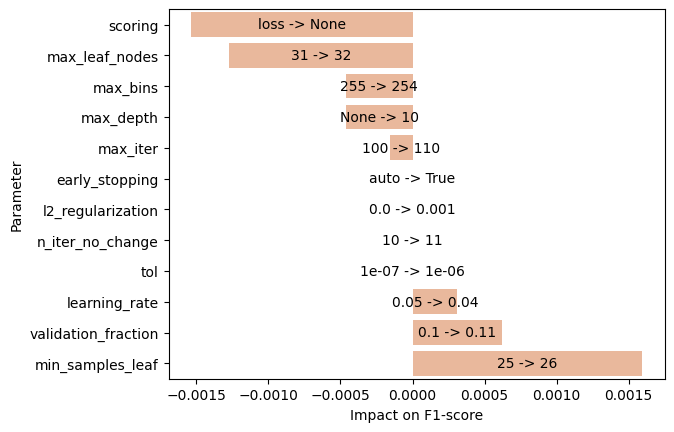

In [20]:
ax = sns.barplot(df, y=df.index, x='parameter_f1_impact')
for i in ax.containers:
    ax.bar_label(i,labels=df.param_changed.tolist(),label_type='center')

plt.ylabel('Parameter')
plt.xlabel('Impact on F1-score')
plt.savefig('../../visuals/sensitivity_analysis.png',bbox_inches='tight')